<a href="https://colab.research.google.com/github/BatoolMM/fastai/blob/master/Chapter_4_Under_the_Hood_Training_a_Digit_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chapter 4. Under the Hood: Training a Digit Classifier**

In [81]:
!pip install -Uqq fastbook
!pip install fastcore
!pip install fastai
!pip install utils

In [82]:
from utils import *
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

In [83]:
?download_images

In [84]:
path = untar_data(URLs.MNIST_SAMPLE)

In [85]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/train'),Path('/root/.fastai/data/mnist_sample/labels.csv')]

In [86]:
(path/'train'/'7').ls()

(#6265) [Path('/root/.fastai/data/mnist_sample/train/7/33681.png'),Path('/root/.fastai/data/mnist_sample/train/7/40214.png'),Path('/root/.fastai/data/mnist_sample/train/7/3788.png'),Path('/root/.fastai/data/mnist_sample/train/7/42544.png'),Path('/root/.fastai/data/mnist_sample/train/7/47325.png'),Path('/root/.fastai/data/mnist_sample/train/7/6147.png'),Path('/root/.fastai/data/mnist_sample/train/7/617.png'),Path('/root/.fastai/data/mnist_sample/train/7/51138.png'),Path('/root/.fastai/data/mnist_sample/train/7/56567.png'),Path('/root/.fastai/data/mnist_sample/train/7/37835.png')...]

In [87]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [88]:
tensor_threes = [tensor(Image.open(i)) for i in threes]
tensor_sevens = [tensor(Image.open(i)) for i in sevens]
tensor_threes[1][4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

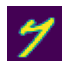

In [89]:
show_image(tensor_sevens[1])

In [90]:
stacked_threes = torch.stack(tensor_threes).float()/255
stacked_sevens = torch.stack(tensor_sevens).float()/255

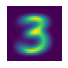

In [91]:
show_image(stacked_threes.mean(0))

In [92]:
abs_three_tomeanthree = (stacked_threes.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanthree = ((stacked_threes.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanthree, rmse_three_tomeanthree

(tensor(0.1114), tensor(0.2021))

In [93]:
abs_three_tomeanseven = (stacked_sevens.mean(0) - stacked_threes[1]).abs().mean()
rmse_three_tomeanseven = ((stacked_sevens.mean(0) - stacked_threes[1])**2).mean().sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

In [94]:
#in pytorch

abs_three_tomeanseven = F.l1_loss(stacked_sevens.mean(0), stacked_threes[1])
rmse_three_tomeanseven = F.mse_loss(stacked_sevens.mean(0) , stacked_threes[1]).sqrt()
abs_three_tomeanseven, rmse_three_tomeanseven

(tensor(0.1586), tensor(0.3021))

## **Validation set**

In [95]:
(path/'valid').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/valid/7'),Path('/root/.fastai/data/mnist_sample/valid/3')]

In [96]:
valid_three = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'3').ls()])
valid_three = valid_three.float()/255
valid_seven = torch.stack([tensor(Image.open(i)) for i in (path/'valid'/'7').ls()])
valid_seven = valid_seven.float()/225
valid_three.shape,valid_seven.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [97]:
mean_seven = stacked_sevens.mean(0)
mean_three = stacked_threes.mean(0)
#without broadcasting
(valid_seven - mean_three).abs().mean(), (valid_seven - mean_three).abs().mean().shape

#with broadcasting
(valid_seven - mean_three).abs().mean((-1,-2)), (valid_seven - mean_three).abs().mean((-1,-2)).shape

(tensor([0.1634, 0.1872, 0.1801,  ..., 0.1995, 0.1434, 0.1712]),
 torch.Size([1028]))

In [98]:
def mnist_l1_loss(a, b):
  return (a - b).abs().mean((-1, -2))

mnist_l1_loss(valid_seven, mean_three,), mnist_l1_loss(valid_seven, mean_three).shape

(tensor([0.1634, 0.1872, 0.1801,  ..., 0.1995, 0.1434, 0.1712]),
 torch.Size([1028]))

In [99]:
def is_three(x):
  mean_seven = stacked_sevens.mean(0)
  mean_three = stacked_threes.mean(0)
  return mnist_l1_loss(x, mean_three) < mnist_l1_loss(x, mean_seven)

is_three(valid_three), is_three(valid_three).float()

(tensor([True, True, True,  ..., True, True, True]),
 tensor([1., 1., 1.,  ..., 1., 1., 1.]))

In [100]:
accuracy_3 = is_three(valid_three).float().mean()
accuracy_7 = (1 - is_three(valid_seven).float()).mean()
accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9864))

## **Gradient descent**

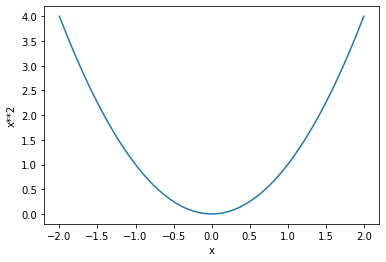

In [101]:
def f(x):
  return x**2

def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

plot_function(f,'x', 'x**2')

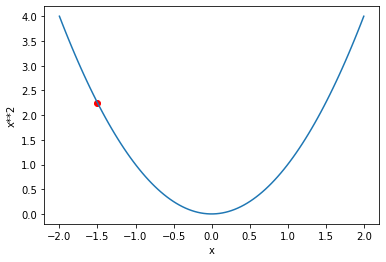

In [102]:
plot_function(f,'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red')

In [103]:
def f(x):
  return x**2

In [104]:
der_x_3 = tensor(3.).requires_grad_()
der_x_3

tensor(3., requires_grad=True)

In [105]:
der_f = f(der_x_3)
der_f

tensor(9., grad_fn=<PowBackward0>)

In [106]:
der_f.backward()
der_x_3.grad

tensor(6.)

## **Roller coaster**

In [107]:
time = torch.arange(20.)
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [108]:
#original speed
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([66.1143, 53.6049, 43.5756, 30.1400, 17.3563, 13.8264, 11.5663,  8.3209,
         5.3578,  2.4086,  1.0273,  3.7305,  2.2552, 11.5627, 13.1747, 22.0237,
        31.2278, 50.0045, 54.3663, 65.2280])

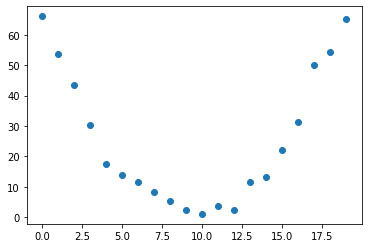

In [109]:
plt.scatter(time, speed)

In [110]:
#the equation
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [111]:
#initi the weights
params = torch.randn(3).requires_grad_()
params

tensor([ 1.3034, -1.2774,  0.9681], requires_grad=True)

In [112]:
#define loss function
def mse(preds, targets):
  return ((targets - preds)**2).mean()

In [113]:
#check the weights with function and lose function
preds = f(time, params)
preds

tensor([  0.9681,   0.9941,   3.6270,   8.8668,  16.7136,  27.1672,  40.2277,
         55.8951,  74.1693,  95.0505, 118.5386, 144.6336, 173.3355, 204.6442,
        238.5599, 275.0825, 314.2119, 355.9483, 400.2916, 447.2417],
       grad_fn=<AddBackward0>)

In [114]:
loss = mse(preds, speed)
loss 

tensor(33998.5117, grad_fn=<MeanBackward0>)

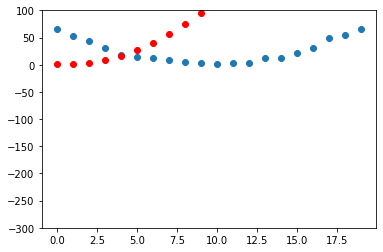

In [115]:
def show_pred(preds, plot=None):
  if plot is None:
    plot = plt.subplots()[1]
    plot.scatter(time, speed)
    plot.scatter(time, to_np(preds), color ='red')
    plot.set_ylim(-300, 100)

show_pred(preds)

In [116]:
loss.backward()
params.grad

tensor([61321.9219,  3921.0115,   248.9296])

In [117]:
 lr = 1e-5
params.data -= lr *params.grad.data
params.grad = None

In [118]:
preds = f(time, params)
mse(preds, speed)

tensor(6906.9248, grad_fn=<MeanBackward0>)

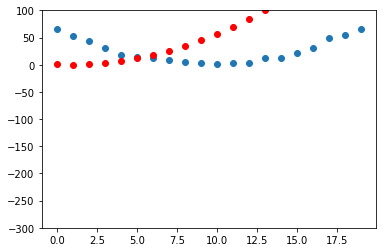

In [119]:
show_pred(preds)

In [120]:
params

tensor([ 0.6902, -1.3166,  0.9656], requires_grad=True)

In [121]:
params.data

tensor([ 0.6902, -1.3166,  0.9656])

In [122]:
def apply_steps(params, prt=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  lr = 1e-5
  params.data -= lr * params.grad.data
  params.grad = None
  if prt:
    print(loss.item())
  return preds

In [123]:
for i in range(10):
  apply_steps(params)

6906.9248046875
1780.3668212890625
810.2601928710938
626.6813354492188
591.9376831054688
585.3579711914062
584.107666015625
583.8660888671875
583.8153076171875
583.8006591796875


## **The MNIST Loss Function**

In [124]:
# make the training into vector
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x.shape, stacked_threes.shape, stacked_sevens.shape

(torch.Size([12396, 784]),
 torch.Size([6131, 28, 28]),
 torch.Size([6265, 28, 28]))

In [125]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [126]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [127]:
dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y.shape

(torch.Size([784]), torch.Size([1]))

In [128]:
valid_x = torch.cat([valid_three, valid_seven]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_three) + [0]*len(valid_seven)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))
valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

In [129]:
def init(size, sd=1):
  return (torch.randn(size)*sd).requires_grad_()

In [130]:
weights = init((28*28, 1))
bias = init(1)
weights.shape, bias.shape

(torch.Size([784, 1]), torch.Size([1]))

In [131]:
pred = (train_x[0]*weights.T).sum() + bias
pred

tensor([4.1402], grad_fn=<AddBackward0>)

In [132]:
def linear(train_x):
  return train_x @ weights + bias

pred = linear(train_x)

In [133]:
pred.shape

torch.Size([12396, 1])

In [134]:
pred

tensor([[  4.1402],
        [-10.3916],
        [ -4.8323],
        ...,
        [ -1.7522],
        [-12.3659],
        [ -8.7766]], grad_fn=<AddBackward0>)

In [135]:
train_y

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])

In [136]:
pred[1]

tensor([-10.3916], grad_fn=<SelectBackward>)

In [137]:
train_y[1]

tensor([1])

In [138]:
correct_3 = (pred>0).float() == train_y
correct_3

tensor([[ True],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [139]:
correct_7 = (pred<0).float() == train_y
correct_7

tensor([[False],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [140]:
correct_3.float().mean().item()

0.5403355956077576

In [141]:
correct_7.float().mean().item()

0.45966440439224243

In [142]:
#This is the same as running the list comprehension 
#[b[i] if a[i] else c[i] for i in range(len(a))], 
#except it works on tensors, at C/CUDA speed. 
def mnist_loss(train_y, pred):
  pred = sigmoid(pred)
  loss = torch.where(train_y == 1, 1 - pred, pred)

In [143]:
# 1- init the weights, bias 
weights = init((28*28, 1))
bias = init(1)

# 2- lets define model 
def linear(train_x):
  params = weights, bias
  return (train_x @ weights) + bias

# 3- loss function:
def mnist_loss(pred, train_y):
  pred = pred.sigmoid()
  return torch.where(train_y ==1, 1-pred, pred).mean()

# 4- create dataloader for tain_dset and valid_dset
dl_train = DataLoader(dset, batch_size=256)
dl_valid = DataLoader(valid_dset, batch_size=256)

# 5- calculate gardient
def calcu_gradient(model, train_x, train_y):
  pred = model(train_x)
  loss = mnist_loss(pred, train_y)
  loss.backward()

# 6- added zero grad to rest , weights.grad.zero_(), bias.grad.zero_() in function

def train_epoch(model, lr, params, dset):
  for train_x, train_y in dset:
    calcu_gradient(model, train_x, train_y)
    for p in params:
      p.data -= p.grad *lr
      p.grad.zero_()

# 7- define accuracy function
def mnist_accuracy(train_y, pred):
  pred = linear(train_x)
  pred = pred.sigmoid()
  correct = (pred>0.5) == train_y
  return correct.float().mean()

# 8- define vlaidation function
def validate_epch(model, valid_dset):
  acc = [mnist_accuracy(yb ,linear(xb)) for xb, yb in valid_dset]
  return round(torch.stack(acc).mean().item(),4)


In [144]:
params = weights, bias
train_epoch(linear, 1, params, dset)

In [145]:
params = weights, bias
for i in range(20):
  train_epoch(linear, 0.01, params, dset[:20])
  print(validate_epch(linear, dset[:20]), sep=" ")


0.0012
0.0012
0.0012
0.0012
0.0012
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013
0.0013


In [146]:
# refactoring our code:
# nn.Linear does the same thing as our init_params and linear together
linear_py = nn.Linear(28*28,1)
w, b = linear_py.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [147]:
# We can create our optimizer by passing in the model’s parameters
class BasicOptim:
  def __init__(self, params, lr):
    self.params = params
    self.lr = lr
  def step(self, *args, **kwargs):
    for p in self.params:
      p.data -= p.grad.data * self.lr
  def zero_grad(self, *args, **kwargs):
    for p in self.params:
      p.grad._zero()

opt = BasicOptim(linear_py.parameters(),1)
opt

In [148]:
def train_epoch(model, dset):
  for train_x, train_y in dset:
    calcu_gradient(model, train_x, train_y)
    opt.step()
    opt.zero_grad()

def train_model(model, epoch, dset):
  for i in range(epoch):
    train_epoch(model, dset)
    return print(validate_epch(model, dset), end=" ")

train_model(linear_py, 20, dset[:30])


0.0013 

In [149]:
# fastai provides the SGD class that, by default, does the same thing as our BasicOptim
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), 1)
train_model(linear_model, 20, dset[:50])

0.0013 

In [150]:
#fastai also provides Learner.fit, which we can use instead of train_model.
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

def mnist_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()


dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, nn.Linear(28*28, 1), 
                opt_func = SGD, 
                lr = 1, 
                loss_func=mnist_loss, 
                metrics=mnist_accuracy)

In [151]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.491823,0.489582,0.604514,00:00
1,0.491683,0.489364,0.606968,00:00
2,0.491522,0.489146,0.609912,00:00
3,0.491347,0.488928,0.611384,00:00
4,0.491163,0.488711,0.614818,00:00
5,0.490975,0.488493,0.615800,00:00
6,0.490785,0.488275,0.617272,00:00
7,0.490595,0.488057,0.620707,00:00
8,0.490403,0.487840,0.623651,00:00
9,0.490212,0.487622,0.624632,00:00


In [ ]:
def simple_net(xb):
  res = xb @ w1 + b1
  res = res.max(tensor(0.0))
  res = xb @ w2 + b2
  return res 


w1 = init((28*28, 30))
b1 = init(30)
w2 = init(30, 1)
b2 = init(1)

simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

learn = Learner(dls, simple_net, lr = 0.1, opt_func=SGD, 
                loss_func=mnist_loss, metrics=mnist_accuracy)

learn.fit(50, lr=lr)

In [164]:
doc(L.itemgot)

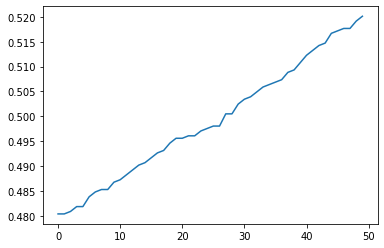

In [167]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [168]:
learn.recorder.values[-1][2]

0.5201177597045898

In [169]:
path

Path('/root/.fastai/data/mnist_sample')

In [175]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1,0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.083602,0.008658,0.997056,00:14
